# Project Model-Mesh Serving Post-Install Demo Script

## Cluster Setup

### Pre-requisites 
- ETCD for meta store
- COS/S3 for model storage

#### Ensure you are logged into the cluster with kubectl or oc

#### Create namespace 'wmlserving'

In [1]:
!oc new-project wmlserving
# ensure in wmlserving namespace
!oc project wmlserving

Using project "wmlserving" on server "api.anhuong-dev-jun-10.cp.fyre.ibm.com"

In [57]:
%cd ../../

/Users/Anh.Uong@ibm.com/github.ibm.com/ai-foundation/model-serving


#### Use install scripts to install Model-Mesh Serving and dependencies (etcd and minio)

In [60]:
# REPLACE ARTIFACTORY_USER and ARTIFACTORY_APIKEY with your credentials
!curl -sSLf -o wmlserving-install.sh -u <ARTIFACTORY_USER>:<ARTIFACTORY_APIKEY> https://na.artifactory.swg-devops.com/artifactory/wcp-ai-foundation-team-generic-virtual/model-serving/wml-serving-0.5.0_165-install.sh
!chmod +x wmlserving-install.sh
!./wmlserving-install.sh -n wmlserving -u <ARTIFACTORY_USER> -a <ARTIFACTORY_APIKEY> --quickstart

env: ARTIFACTORY_USER="anh.uong@ibm.com"
curl: (22) The requested URL returned error: 401


In [63]:
# Model-Mesh Serving should be installed
!kubectl get all

NAME                                         READY   STATUS    RESTARTS   AGE
pod/wmlserving-controller-568c45b959-xfzlk   1/1     Running   0          6m38s

NAME                  TYPE        CLUSTER-IP   EXTERNAL-IP   PORT(S)    AGE
service/wml-serving   ClusterIP   None         <none>        8033/TCP   21m

NAME                                            READY   UP-TO-DATE   AVAILABLE   AGE
deployment.apps/wml-serving-mlserver-0.x        0/0     0            0           21m
deployment.apps/wml-serving-msp-ml-server-0.x   0/0     0            0           21m
deployment.apps/wml-serving-triton-2.x          0/0     0            0           21m
deployment.apps/wmlserving-controller           1/1     1            1           22m

NAME                                                       DESIRED   CURRENT   READY   AGE
replicaset.apps/wml-serving-mlserver-0.x-78fcbcbc6d        0         0         0       21m
replicaset.apps/wml-serving-msp-ml-server-0.x-57c69c6bfb   0         0         0

#### Pre-req for Triton serving for OCP

In [61]:
!oc adm policy add-scc-to-user anyuid system:serviceaccount:model-serving:wmlserving

clusterrole.rbac.authorization.k8s.io/system:openshift:scc:anyuid added: "wmlserving"


## Local Setup

In [3]:
# install python dependencies
!pip3 install grpcio grpcio-tools numpy matplotlib

     |████████████████████████████████| 3.9 MB 5.8 MB/s eta 0:00:01
     |████████████████████████████████| 2.0 MB 35.1 MB/s eta 0:00:01
You should consider upgrading via the '/usr/local/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip' command.


In [79]:
# Download data for MNIST
!curl -sSLfo mnist.npz https://s3.amazonaws.com/img-datasets/mnist.npz

# Download triton grpc protos
!curl -sSfLo model_config.proto "https://raw.githubusercontent.com/triton-inference-server/server/v2.10.0/src/core/model_config.proto"
!curl -sSfLo grpc_service.proto "https://raw.githubusercontent.com/triton-inference-server/server/v2.10.0/src/core/grpc_service.proto"

In [76]:
!python -m grpc_tools.protoc -I. --python_out=. --grpc_python_out=. grpc_service.proto model_config.proto

In [77]:
import grpc
import grpc_service_pb2
import grpc_service_pb2_grpc

## Deploy Predictor and Run Inference

### Secret Key for storage should be added to secret "storage-config"

```yaml
apiVersion: v1
kind: Secret
metadata:
    name: storage-config
stringData:
    myStorage: |
        {
            "type": "s3",
            "access_key_id": "xxx",
            "secret_access_key": "xxx",
            "endpoint_url": "https://s3.us-south.cloud-object-storage.appdomain.cloud",
            "region": "us-south",
            "default_bucket": ""
        }

```

In [65]:
# To use the shared wml-serving COS instance:
!kubectl patch secret/storage-config -p '{"data": {"wml-serving-example-models": "ewogICJ0eXBlIjogInMzIiwKICAiYWNjZXNzX2tleV9pZCI6ICJlY2I5ODNmMTE4MjI0MjNjYTllNDg3Zjg5OGQ1NGE4ZiIsCiAgInNlY3JldF9hY2Nlc3Nfa2V5IjogImNkYmVmZjZhMzJhZWY2YzIzNzRhZTY5ZWVmNTAzZTZkZDBjOTNkNmE3NGJjMjQ2NyIsCiAgImVuZHBvaW50X3VybCI6ICJodHRwczovL3MzLnVzLXNvdXRoLmNsb3VkLW9iamVjdC1zdG9yYWdlLmFwcGRvbWFpbi5jbG91ZCIsCiAgInJlZ2lvbiI6ICJ1cy1zb3V0aCIsCiAgImRlZmF1bHRfYnVja2V0IjogIndtbC1zZXJ2aW5nLWV4YW1wbGUtbW9kZWxzLXB1YmxpYyIKfQo="}}'

secret/storage-config patched (no change)


### Submit Predictor CR

In [ ]:
!kubectl get predictors

In [66]:
%%bash
# SecretKey "wml-serving-example-models" added above is used
cat <<EOF | kubectl apply -f -
apiVersion: wmlserving.ai.ibm.com/v1
kind: Predictor
metadata:
  name: example-tensorflow-mnist
spec:
  modelType:
    name: tensorflow
  path: tensorflow/mnist.savedmodel
  storage:
    s3:
      secretKey: wml-serving-example-models
EOF

predictor.wmlserving.ai.ibm.com/example-tensorflow-mnist created


In [105]:
%%bash
# SecretKey "wml-serving-example-models" added above is used
cat <<EOF | kubectl apply -f -
apiVersion: wmlserving.ai.ibm.com/v1
kind: Predictor
metadata:
  name: example-sklearn-mnist-svm
spec:
  modelType:
    name: sklearn
  path: sklearn/mnist-svm.joblib
  storage:
    s3:
      secretKey: wml-serving-example-models
EOF

predictor.wmlserving.ai.ibm.com/example-sklearn-mnist-svm created


###  Predictors Status

This may take a few minutes to load while the runtime pods are brought up.
Wait for the state of the Predictors to become 'Loaded'

In [73]:
!kubectl get predictors
!kubectl get pods

NAME                        TYPE         AVAILABLE   ACTIVEMODEL   TARGETMODEL   TRANSITION   AGE
example-sklearn-mnist-svm   sklearn      true        Loaded                      UpToDate     2m7s
example-tensorflow-mnist    tensorflow   true        Loaded                      UpToDate     2m34s
NAME                                             READY   STATUS    RESTARTS   AGE
wml-serving-msp-ml-server-0.x-57c69c6bfb-vl9wf   3/3     Running   1          2m7s
wml-serving-msp-ml-server-0.x-57c69c6bfb-x7rbt   3/3     Running   1          2m7s
wml-serving-triton-2.x-6c9784c9db-m875r          3/3     Running   0          2m34s
wml-serving-triton-2.x-6c9784c9db-shq9f          3/3     Running   0          2m34s
wmlserving-controller-568c45b959-xfzlk           1/1     Running   0          13m


## Inference using KFServing V2 dataplane API

### Plotting test data

In [80]:
import numpy as np

dataset = np.load("mnist.npz")
x_test = dataset['x_test']

In [81]:
%matplotlib inline
import matplotlib.pyplot as plt

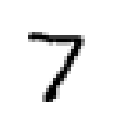

In [82]:
# Image should look like 7
for i, image in enumerate([x_test[0]]):
    plt.subplot(2, 2, i + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')

In [83]:
score_0 = x_test[0].flatten().tolist()

### Tensorflow Inference

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

Run the following command in a separate terminal to forward grpc calls to the cluster. This is needed for inferencing.

`kubectl port-forward --address 0.0.0.0 service/wml-serving 8033 -n wmlserving`

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

In [100]:
channel = grpc.insecure_channel('0.0.0.0:8033')

In [101]:
infer_client = grpc_service_pb2_grpc.GRPCInferenceServiceStub(channel)

In [102]:
tensor_contents = grpc_service_pb2.InferTensorContents(fp32_contents=score_0)
infer_input=grpc_service_pb2.ModelInferRequest().InferInputTensor(name="inputs",shape=[1,784],datatype="FP32",contents=tensor_contents)

In [104]:
# Expect prediction to be 7
inputs=[]
inputs.append(infer_input)
request=grpc_service_pb2.ModelInferRequest(model_name="example-tensorflow-mnist",inputs=inputs)

results,call=infer_client.ModelInfer.with_call(request=request)
print("model_name : "+results.model_name+"\n"+"model_version : "+results.model_version + "\n"
     "prediction : "+str(list(results.raw_output_contents[0])[0]))

model_name : example-tensorflow-mnist-cca986bcf1
model_version : 1
prediction : 7


### MLServer Inference

Using grpcurl

In [106]:
# !brew install grpcurl
!grpcurl --version

grpcurl 1.8.1


In [110]:
!grpcurl -plaintext -proto fvt/proto/kfs_inference_v2.proto 0.0.0.0:8033 list inference.GRPCInferenceService

inference.GRPCInferenceService.ModelInfer
inference.GRPCInferenceService.ModelMetadata
inference.GRPCInferenceService.ModelReady
inference.GRPCInferenceService.ServerLive
inference.GRPCInferenceService.ServerMetadata
inference.GRPCInferenceService.ServerReady


#### Run the following command in a separate terminal to forward grpc calls to the cluster. This is needed for inferencing.

`kubectl port-forward --address 0.0.0.0 service/wml-serving 8033 -n wmlserving`

In [114]:
# Expect contents of output to be 8
!grpcurl -plaintext -proto fvt/proto/kfs_inference_v2.proto -d '{ "model_name": "example-sklearn-mnist-svm", "inputs": [{ "name": "predict", "shape": [1, 64], "datatype": "FP32", "contents": { "fp32_contents": [0.0, 0.0, 1.0, 11.0, 14.0, 15.0, 3.0, 0.0, 0.0, 1.0, 13.0, 16.0, 12.0, 16.0, 8.0, 0.0, 0.0, 8.0, 16.0, 4.0, 6.0, 16.0, 5.0, 0.0, 0.0, 5.0, 15.0, 11.0, 13.0, 14.0, 0.0, 0.0, 0.0, 0.0, 2.0, 12.0, 16.0, 13.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 16.0, 16.0, 6.0, 0.0, 0.0, 0.0, 0.0, 16.0, 16.0, 16.0, 7.0, 0.0, 0.0, 0.0, 0.0, 11.0, 13.0, 12.0, 1.0, 0.0] }}]}' 0.0.0.0:8033 inference.GRPCInferenceService.ModelInfer

{
  "modelName": "example-sklearn-mnist-svm-725d74f061",
  "outputs": [
    {
      "name": "predict",
      "datatype": "FP32",
      "shape": [
        "1"
      ],
      "contents": {
        "fp32Contents": [
          8
        ]
      }
    }
  ]
}
